# The effects of precision

Examining how varying precision (inverse variance) levels on the likelihood and prior affect the posterior distribution

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys

mpl.style.use("seaborn-deep")

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utils import create_agent, create_environment
from src.maths import std_to_precision

The last example demonstrated how to perform Bayesian inference with a probabilistic generating function and Gaussian prior. In this example we examine the effects of how different levels of variance (or the inverse of variance, precision) can affect the Bayesian inference process. This will become very important in future examples of active inference agents whose behavior is very sensitive to levels of precision/variance.

We will use a probabilistic agent with a linear generating function in this example. This example also introduces the use of preset agents and environments that are included in the code base. These agents make it very easy to quickly run experiments with agents of our choosing.

First we create the environment which will generate sensory data $y=7$.

In [2]:
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 1e-5   # Standard deviation of sensory data
}

# Initialize environment
env = create_environment(name="static_linear", params=env_params)

# Generate data
x_range = np.linspace(start=0.01, stop=5, num=500)
x_star = 2

env.build(x_star)
y = env.generate()

We will be interested in two types of agent, each with different settings for precision (inverse variance) on the likelihood or posterior.

Agent 1 will have $\sigma_y=2$ and $\sigma_x=0.1$. Agent 2 will have $\sigma_y=0.1$ and $\sigma_x=2$. To calculate the precision we must first square the standard deviation to get the variance and then take the reciprocal. Below we use a helper function `std_to_precision()` to do this.


In [3]:
# Agent parameters
agent_1_params = {
    "beta_0" : 3,    # Linear parameter intercept
    "beta_1" : 2,    # Linear parameter slope
    "std_y"  : 2,    # Likelihood standard deviation
    "m_x"   : 4,     # Prior mean
    "s_x"  : 0.1,    # Prior standard deviation
    "x_range": np.linspace(start=0.01, stop=5, num=500)
}

agent_2_params = {
    "beta_0" : 3,    # Linear parameter intercept
    "beta_1" : 2,    # Linear parameter slope
    "std_y"  : 0.1,  # Likelihood standard deviation
    "m_x"   : 4,     # Prior mean
    "s_x"  : 2,      # Prior standard deviation
    "x_range": np.linspace(start=0.01, stop=5, num=500)
}

agent_1_likelihood_precision = np.round(std_to_precision(agent_1_params["std_y"]), 3)
agent_2_likelihood_precision = np.round(std_to_precision(agent_2_params["std_y"]), 3)
agent_1_prior_precision = np.round(std_to_precision(agent_1_params["s_x"]), 3)
agent_2_prior_precision = np.round(std_to_precision(agent_2_params["s_x"]), 3)

print(f"Agent 1 likelihood precision: {agent_1_likelihood_precision}")
print(f"Agent 2 likelihood precision: {agent_2_likelihood_precision}")
print(f"Agent 1 prior precision: {agent_1_prior_precision}")
print(f"Agent 2 prior precision: {agent_2_prior_precision}")

Agent 1 likelihood precision: 0.25
Agent 2 likelihood precision: 100.0
Agent 1 prior precision: 100.0
Agent 2 prior precision: 0.25


From this we can conclude:
* Agent 1 has low likelihood precision and high prior precision
* Agent 2 has high likelihood precision and low prior precision

Since precision can be seen as a measure of confidence we can say
* Agent 1 is more confident in its prior
* Agent 2 is more confident in its likelihood

In [4]:
agent_1 = create_agent(name="exact_linear", params=agent_1_params)
agent_2 = create_agent(name="exact_linear", params=agent_2_params)

# Perform inference
agent_1.build(y)
agent_2.build(y)
agent_1.infer_state()
agent_2.infer_state()

# Collect distributions for plotting
prior1 = agent_1.prior
prior2 = agent_2.prior
likelihood1 = agent_1.likelihood
likelihood2 = agent_2.likelihood
posterior1 = agent_1.posterior
posterior2 = agent_2.posterior

<Figure size 432x288 with 0 Axes>

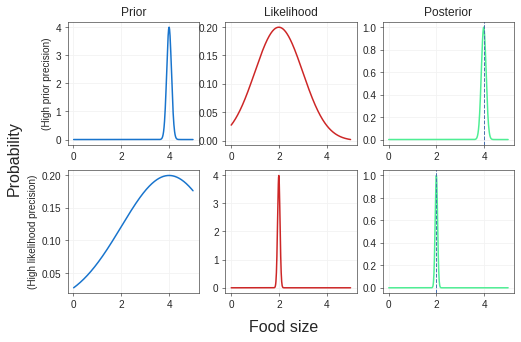

In [5]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(2,3, facecolor=(1,1,1), figsize=(8,5))

# Top row
axes[0,0].plot(x_range.tolist(), prior1, c="#1874cd")        # Prior
axes[0,1].plot(x_range.tolist(), likelihood1, c="#cd2626")   # Likelihood
axes[0,2].plot(x_range.tolist(), posterior1, c="#4eee94")    # Posterior

# Bottom row
axes[1,0].plot(x_range.tolist(), prior2, c="#1874cd")        # Prior
axes[1,1].plot(x_range.tolist(), likelihood2, c="#cd2626")   # Likelihood
axes[1,2].plot(x_range.tolist(), posterior2, c="#4eee94")    # Posterior

# Posterior vertical line
axes[0,2].axvline(x=(np.argmax(posterior1) + 1) / 100, ls="dashed", lw=1)
axes[1,2].axvline(x=(np.argmax(posterior2) + 1) / 100, ls="dashed", lw=1)

# Titles
axes[0,0].set_title("Prior")
axes[0,1].set_title("Likelihood")
axes[0,2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Descriptions
axes[0,0].set_ylabel("(High prior precision)")
axes[1,0].set_ylabel("(High likelihood precision)")

# Cosmetic changes and axes ranges
for ax in axes.reshape(-1):
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    

These results confirm that the inference process will be dominated by which distribution has higher precision.
* *If the likelihood precision is high, the agent will rely mostly on the data for state inference*
* *If the prior precision is high, the agent will rely mostly on its prior for state inference*

Top top panel shows agent 1 which has high prior precision. The prior is centered over $m_x=4$ and so the posterior is heavily biased by the prior. The bottom panel shows agent 2 which has a high likelihood precision. The likelihood is centered over $\mu_x=2$ and so the posterior is heavily biased by the data.

This example demonstrates that the amount of precision can have a strong effect on the inference process. Later in the book we will see that this is the essence of the perception process: How much do we trust our priors over the sensory data we are receiving? Precision plays a key role in this process as well as other processes like attention.